# Proyecto 1 - Análitica de textos - Etapa 1

## Integrantes
- Carlos Vargas - 202220064
- Silvana Echeverry - 202310470
- David Mora - 202226269

El objetivo del proyecto es construir un modelo de aprendizaje supervisado de clasificación de texto. Se espera que dado un nuevo texto de opinión, el modelo debe predecir automáticamente a cuál ODS pertenece. No es una variable binaria sino multiclase (1,3,4)

# 2. Entendimiento y preparación de los Datos

## Entendimiento - Carga de Datos

In [1]:
# Manejo de datos
import pandas as pd
import numpy as np

# Preprocesamiento
import re, unicodedata
import spacy  # lematización en español

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Vectorización
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Split de train/test
from sklearn.model_selection import train_test_split

# Modelos
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Métricas y evaluación
from sklearn.metrics import (
    classification_report,
    f1_score,
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    roc_curve,
    auc
)
from sklearn.preprocessing import label_binarize

In [2]:
!python -m spacy download es_core_news_sm
nlp = spacy.load("es_core_news_sm")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 41.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [3]:
data = pd.read_excel('Datos_proyecto.xlsx')
#print(data.head())
#data.info()

Revisar como estan distribuidos nuestros datos:

1. Contar cuantos labels hay, lo cual nos confirma que tenemos, para confirmar si tenemos desbalanceo o balanceo en nuestras clases
- 4 1025 (Calidad de vida)
-  3 894 (salud)
- 1 505 (educación)
2. Ver la proporción que representa cada clase con respecto al total de los datos.
- 4 42%
- 3 36%
- 1 20% menor representación
el label 4 y 3 estan mas parejas

3. Mostrar la grafica
- con la grafica podemos ver que nuestras label tienen un leve desbalance pero consideramos que podemos seguir trabajando


labels
4    1025
3     894
1     505
Name: count, dtype: int64
labels
4    0.422855
3    0.368812
1    0.208333
Name: proportion, dtype: float64


/tmp/ipython-input-405444549.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='labels', data=data, palette="Set2")


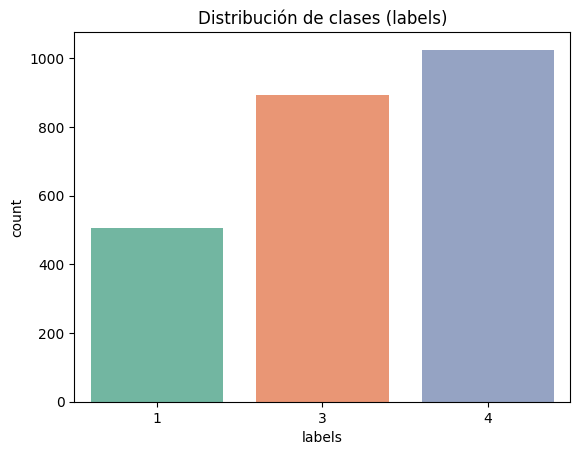

In [4]:
# Conteo de ejemplos por clase
print(data['labels'].value_counts())

# Proporción de ejemplos por clase
print(data['labels'].value_counts(normalize=True))

sns.countplot(x='labels', data=data, palette="Set2")
plt.title("Distribución de clases (labels)")
plt.show()

Con esto verificamos las longitudes de los textos y las palabras antes de limpiarlas.

In [5]:
data_copy = data.copy()
data_copy['conteo'] = [len(x) for x in data_copy['textos']]
data_copy['max'] = [[max([len(x) for x in i.split(' ')])][0] for i in data_copy['textos']]
data_copy['min'] = [[min([len(x) for x in i.split(' ')])][0] for i in data_copy['textos']]
data_copy['mean'] = [np.mean([len(x) for x in i.split(' ')]) for i in data_copy['textos']]

data_copy


,textos,labels,conteo,max,min,mean
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4,352,14,1,6.354167
1,Para los niños más pequeños (bebés y niños peq...,4,516,16,1,6.180556
2,"Además, la formación de especialistas en medic...",3,659,15,1,6.096774
3,En los países de la OCDE se tiende a pasar de ...,4,693,18,1,5.366972
4,Este grupo se centró en las personas que padec...,3,608,14,0,5.410526
...,...,...,...,...,...,...
2419,La tutoría de carrera está diseñada para apoya...,4,741,16,1,5.566372
2420,Fuente: Ministerio de Educación. Las Tasas Int...,4,541,15,1,5.376471
2421,"Y desde 2010, el PNUD ha sido pionero en la pu...",1,352,12,1,4.515625
2422,"Sin embargo, estas fallas del mercado implican...",3,754,15,1,4.852713


## Procesamiento de los Datos
#### Limpieza de los datos

En la parte de limpieza de los datos vamos a dejar todo en minusculas, eliminar caracteres especiales, puntuación, nonASCII characters y stopwords  

In [6]:
def limpieza_y_lematizacion(texto: str) -> str:
    #minúsculas
    texto = str(texto).lower()

    #acentos / non-ASCII
    texto = ''.join(c for c in unicodedata.normalize('NFD', texto)
                    if unicodedata.category(c) != 'Mn')

    # puntuación y caracteres especiales
    texto = re.sub(r'[^a-z0-9\s]', ' ', texto)

    # procesar con spaCy y devolver lemas sin stopwords ni puntuación
    doc = nlp(texto)
    lemas = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]

    # Reconstruir texto limpio
    return " ".join(lemas)



#### Tokenización
Vamos a dividir en frases u oraciones en palabras Con el fin de desglozar las palabras correctamente para el posterior análisis. Como en español no hay contractions no aplicamos esa función. Sin embargo, tenemos en cuenta también las palabras compuestas como niños(as) estas las separamos en tokens diferentes, ademas podemos eliminar comillas, parentesis y guiones.

In [7]:
def tokenizacion(texto: str):
    tokens = re.findall(r"[a-zA-ZáéíóúÁÉÍÓÚñÑüÜ0-9]+", texto)
    return tokens

#### Normalizacion
Aqui eliminamos las stopwords.
- Se utilizo chat gpt para que generara la lista con las spanish stopwords que queremos eliminar, ya que generalmente las librerias estan en ingles y no reconocen las stopwords en español

In [8]:
spanish_stopwords = [
    'a', 'acá', 'ahí', 'ajena', 'ajenas', 'ajeno', 'ajenos', 'al', 'algo', 'algún',
    'alguna', 'algunas', 'alguno', 'algunos', 'allá', 'allí', 'ambos', 'ante',
    'antes', 'aquel', 'aquella', 'aquellas', 'aquello', 'aquellos', 'aquí',
    'arriba', 'así', 'atrás', 'aun', 'aunque', 'bajo', 'bastante', 'bien', 'cabe',
    'cada', 'casi', 'cierta', 'ciertas', 'cierto', 'ciertos', 'como', 'con',
    'conmigo', 'contigo', 'contra', 'cual', 'cuales', 'cualquier', 'cualquiera',
    'cualquieras', 'cuan', 'cuando', 'cuanta', 'cuantas', 'cuanto', 'cuantos',
    'de', 'dejar', 'del', 'demás', 'demasiada', 'demasiadas', 'demasiado',
    'demasiados', 'dentro', 'desde', 'donde', 'dos', 'el', 'él', 'ella', 'ellas',
    'ello', 'ellos', 'empleáis', 'emplean', 'emplear', 'empleas', 'empleo', 'en',
    'encima', 'entonces', 'entre', 'era', 'eramos', 'eran', 'eras', 'eres', 'es',
    'esa', 'esas', 'ese', 'eso', 'esos', 'esta', 'estaba', 'estado', 'estáis',
    'estamos', 'estan', 'estar', 'estas', 'este', 'esto', 'estos', 'etc', 'ha',
    'hace', 'haces', 'hacéis', 'hacemos', 'hacen', 'hacer', 'hacia', 'hago',
    'hasta', 'incluso', 'intenta', 'intentáis', 'intentamos', 'intentan',
    'intentar', 'intentas', 'intento', 'ir', 'jamás', 'junto', 'juntos', 'la',
    'lo', 'los', 'las', 'largo', 'más', 'me', 'menos', 'mi', 'mía', 'mías', 'mío',
    'míos', 'mis', 'misma', 'mismas', 'mismo', 'mismos', 'modo', 'mucha', 'muchas',
    'muchísima', 'muchísimas', 'muchísimo', 'muchísimos', 'mucho', 'muchos', 'muy',
    'nada', 'ni', 'ninguna', 'ningunas', 'ninguno', 'ningunos', 'no', 'nos',
    'nosotras', 'nosotros', 'nuestra', 'nuestras', 'nuestro', 'nuestros', 'nunca',
    'os', 'otra', 'otras', 'otro', 'otros', 'para', 'parecer', 'pero', 'poca',
    'pocas', 'poco', 'pocos', 'podeis', 'podemos', 'poder', 'podría', 'podríais',
    'podríamos', 'podrían', 'por', 'porque', 'primero', 'puede', 'pueden', 'puedo',
    'pues', 'que', 'querer', 'quien', 'quienes', 'quienesquiera', 'quienquiera',
    'quizá', 'quizás', 'sabe', 'sabes', 'saben', 'sabéis', 'sabemos', 'saber',
    'se', 'según', 'ser', 'si', 'sí', 'siendo', 'sin', 'sino', 'so', 'sobre',
    'sois', 'solamente', 'solo', 'somos', 'soy', 'su', 'sus', 'suya', 'suyas',
    'suyo', 'suyos', 'tal', 'tales', 'también', 'tampoco', 'tan', 'tanta',
    'tantas', 'tanto', 'tantos', 'te', 'teneis', 'tenemos', 'tener', 'tengo',
    'ti', 'tiempo', 'tiene', 'tienen', 'toda', 'todas', 'todo', 'todos', 'tras',
    'tu', 'tus', 'tuya', 'tuyas', 'tuyo', 'tuyos', 'un', 'una', 'unas', 'uno',
    'unos', 'usa', 'usáis', 'usamos', 'usan', 'usar', 'usas', 'uso', 'usted',
    'ustedes', 'va', 'vais', 'valor', 'vamos', 'van', 'varias', 'varios', 'vaya',
    'verdad', 'verdadera', 'vosotras', 'vosotros', 'voy', 'vuestra', 'vuestras',
    'vuestro', 'vuestros', 'y', 'ya'
]
def normalizacion(tokens):
    return [t for t in tokens if t not in spanish_stopwords]

Juntar todo lo que hicimos, en una copia de nuestros datos

In [9]:
data_copy = data.copy()

# Aplicar las funciones de preprocesamiento
data_copy['textos_clean'] = data_copy['textos'].apply(limpieza_y_lematizacion)
data_copy['tokens'] = data_copy['textos_clean'].apply(tokenizacion)
data_copy['tokens_norm'] = data_copy['tokens'].apply(normalizacion)


# print(data_copy[['tokens_norm','labels']].head(3))
#data_copy

In [10]:
# exportar a excel para saber como nos esta quedando
#data_copy[['textos','tokens_norm']].to_excel("tokens_norm.xlsx", index=False)
#data_copy[['textos','tokens_norm']].to_excel("tokens_norm_lema.xlsx", index=False)

#### Selección de campos y vectorizacion
Esto nos permite traducir nuestras palabras ya tokenizadas en numeros ya que los modelos que vamos a usar no nos funcionan con palabras sino con numeros.
Basicamente lo que vamos a hacer es:
1. Selección de campos: separar que columna es la variable predictora y cual es la variable objetivo (lo organiza para que sklearn lo entienda)
2. Vectorización: convierte cada texto en un vector indicando cuántas veces aparece cada palabra.
3. TfidfVectorizer: pondera cada palabra por su importancia en el documento y en el corpus. penaliza palabras que no nos esten aportantando tanto y favore a las que si.
4. Construcción de la matriz: construimos una matriz de documentos vs vocabulario,
- Cada fila = un documento (texto del dataset).
- Cada columna = una palabra del vocabulario.
- El valor = la frecuencia o el peso TF-IDF de esa palabra en ese documento.

Entonces, esto va a traducir el texto en números para que los modelos puedan trabajar. Además, esta matriz sirve para identificar palabras relevantes en cada clase, lo cual necesitamos para justificar cómo los textos se relacionan con los ODS.

Hacemos la selección de campos

In [11]:
data_ready = data_copy.copy()

data_ready['words'] = data_ready['tokens_norm'].apply(lambda xs: ' '.join(map(str, xs)))

X_data = data_ready['words']
y_data = data_ready['labels'].astype(int)

#print(X_data.head(2))
#print(y_data.value_counts().sort_index())

Vectorización

Presencia binaria (Bag-of-Words binario): No importa cuántas veces aparezca una palabra en el texto. Solo se indica si la palabra está presente (1) o ausente (0).

In [12]:
dummy = CountVectorizer(binary=True)
X_dummy = dummy.fit_transform(X_data)

#print("BoW binario:", X_dummy.shape)

Conteo (Bag-of-Words con frecuencias): Cada palabra del vocabulario se representa con la cantidad de veces que aparece en el documento.

In [13]:
count = CountVectorizer()
X_count = count.fit_transform(X_data)
#print("BoW conteo:", X_count.shape)

TF–IDF: toma lo anterior y le asigna un peso para la matriz

In [14]:
tfidf = TfidfVectorizer(
    min_df=5,        # ignora términos muy raros (<5 documentos)
    max_df=0.9,      # ignora términos demasiado comunes (>90% de documentos)
    lowercase=False,      # ya está en minúsculas
    strip_accents=None, # ya quitaste tildes
    sublinear_tf=True,  #textos largos no dominen
    ngram_range=(1,1) # luego probamos (1,2) para bigramas como "salud publica"
)
X_tfidf = tfidf.fit_transform(X_data)

#print("TF-IDF:", X_tfidf.shape)

Dvidir en data train y data test

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_data, test_size=0.2, stratify=y_data, random_state=42
)

# Ajustar TF-IDF solo con train
tfidf = TfidfVectorizer(min_df=5, max_df=0.9, ngram_range=(1,1))
Xtr = tfidf.fit_transform(X_train)
Xte = tfidf.transform(X_test)

#print(Xtr.shape, Xte.shape)

print("Distribución train:", np.bincount(y_train)/len(y_train))
print("Distribución test :", np.bincount(y_test)/len(y_test))

Distribución train: [0.         0.20835482 0.         0.36874678 0.4228984 ]
Distribución test : [0.         0.20824742 0.         0.36907216 0.42268041]


Lo anterior nos dice que
el 20% de los textos son de la clase 1 - fin de la pobreza
el 36% de los textos son de la clase 3 - salud y bienestar
el 42% de los textos son de la clase 4 - educación y calidad

lo mismo que nos estaba dando al inicio, lo cual indica que nuestro modelo si logro hacer el split correctamente, asegurando que verá ejemplos representativos de todas las clases en train y test.

# 3. Modelado y evaulación

## Naive Bayes - Silvana Echeverry

Como primer algoritmo vamos a utilizar Naive Bayes. Este es muy sencillo y rapido ya que se ajusta a matrices de tamaños muy grandes como la que construimos en TF-IDF. Además, nos da el indicador probabilistico ya que nos ayuda a saber cual clase es más probable en el texto. Es un algoritmo que se usa generalmente en clasificaciones de textos, ya que tiene un baseline clásico (un modelo inicial, sencillo y fácil de implementar, que sirve como punto de comparación para evaluar si los modelos más complejos realmente aportan mejoras.). Nos ayuda a entender y comparar ventajas y desventajas.

##### Tipos de Naive Bayes en SKLEARN
1. Gaussian Naive Bayes: asume que los datos (features) siguen una distribución gaussiana entonces lo hace util para datos continuos, no para textos
2. Multinomial Naive Bayes: supone que los datos son conteos o frecuencias, lo cual lo hace ideal para Bag-of-Words y TF-IDF
3. Complement Naive Bayes: esta diseñado para datos desbalanceados,
4. Bernoulli Naive Bayes: Usa variables binarias (0/1 si una palabra aparece o no), util con BoW binario, no tanto con TF-IDF.
5. Categorical Naive Bayes: Diseñado para features categóricas discretas, No sirve para TF-IDF ni BoW porque no sirve para textos
6. Out-of-core naive Bayes model fitting: Variante de MultinomialNB o BernoulliNB para entrenar en datasets enormes que no caben en memoria.

A partir de estos tipos el mejor que nos funcionaria en este caso es Multinomial Naive Bayes y Complement Naive Bayes.

#### Multinomial Naive Bayes

Aca quiero verificar con cual alpha es mejor. que es mi hiperparámetro

¿Qué es un alpha? el alpha controla cuánto “rellenamos” las probabilidades para evitar que sean cero cuando una palabra no aparece en los datos de entrenamiento de cierta clase. Sin suavizar la probabilidad  haría que cualquier texto con esa palabra jamás se clasifique.

Lo que estoy haciendo es entrenar varios modelos con diferentes valores de alpha y medir el F1-macro en el conjunto de datos de prueba.
De esa forma puedes elegir el alpha que dé mejor rendimiento en tu dataset, en lugar de aceptar ciegamente el valor por defecto

Basicamente un busqueda hice la hiperparametros

In [16]:
alphas = [0.1, 0.3, 0.5, 1.0, 2.0,100, 20, 50, 0.05, 0.7, 0.6, 0.55, 0.33, 0.2, 0.25, 0.15, 0.31, 0.35, 0.65, 0.71, 0.72, 0.69, 0.75, 0.8, 0.85]
scores = []

for a in alphas:
    m = MultinomialNB(alpha=a, fit_prior=True)
    m.fit(Xtr, y_train)
    pred = m.predict(Xte)
    f1m = f1_score(y_test, pred, average='macro')
    scores.append((a, f1m))
    print(f"alpha={a:<4} -> F1-macro={f1m:.4f}")

# Mejor alpha
best_alpha, best_f1 = max(scores, key=lambda x: x[1])
print(f"\nMejor alpha: {best_alpha} (F1-macro={best_f1:.4f})")

alpha=0.1  -> F1-macro=0.9438
alpha=0.3  -> F1-macro=0.9514
alpha=0.5  -> F1-macro=0.9513
alpha=1.0  -> F1-macro=0.9421
alpha=2.0  -> F1-macro=0.9329
alpha=100  -> F1-macro=0.4499
alpha=20   -> F1-macro=0.6982
alpha=50   -> F1-macro=0.5270
alpha=0.05 -> F1-macro=0.9334
alpha=0.7  -> F1-macro=0.9527
alpha=0.6  -> F1-macro=0.9486
alpha=0.55 -> F1-macro=0.9486
alpha=0.33 -> F1-macro=0.9514
alpha=0.2  -> F1-macro=0.9506
alpha=0.25 -> F1-macro=0.9489
alpha=0.15 -> F1-macro=0.9506
alpha=0.31 -> F1-macro=0.9514
alpha=0.35 -> F1-macro=0.9514
alpha=0.65 -> F1-macro=0.9527
alpha=0.71 -> F1-macro=0.9527
alpha=0.72 -> F1-macro=0.9527
alpha=0.69 -> F1-macro=0.9527
alpha=0.75 -> F1-macro=0.9483
alpha=0.8  -> F1-macro=0.9483
alpha=0.85 -> F1-macro=0.9404

Mejor alpha: 0.7 (F1-macro=0.9527)


A partir de lo anterior, nos podemos dar cuenta que el mejor alpha es 0.7 y es el que usamos en nuestro modelo multinomial

Para train

              precision    recall  f1-score   support

           1      0.975     0.975     0.975       404
           3      0.994     0.982     0.988       715
           4      0.984     0.995     0.990       820

    accuracy                          0.986      1939
   macro avg      0.985     0.984     0.984      1939
weighted avg      0.986     0.986     0.986      1939

F1-macro (train): 0.9843249467832945
Accuracy (train): 0.9860752965446106


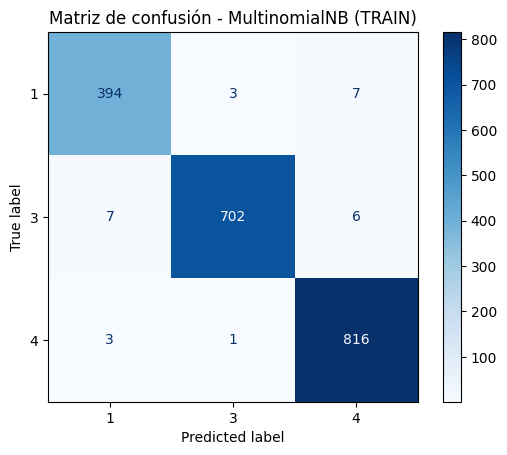


ROC AUC (TRAIN, macro OVR): 0.9993406178556516


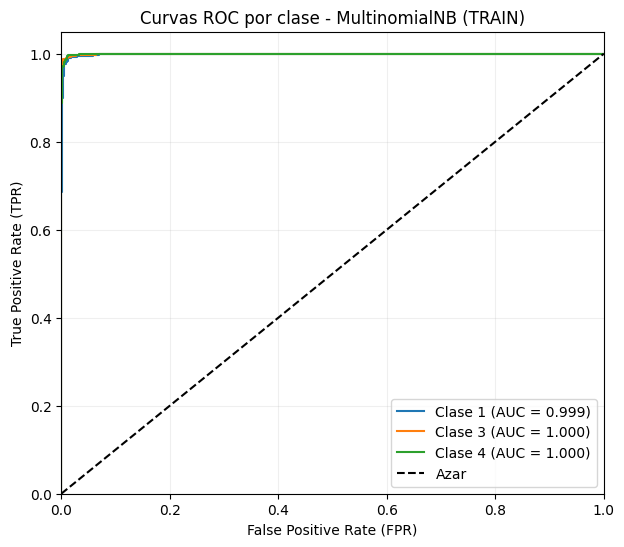

In [17]:
mnb = MultinomialNB(alpha=0.7, fit_prior=True)
mnb.fit(Xtr, y_train)

y_pred_train = mnb.predict(Xtr)


print(classification_report(y_train, y_pred_train, digits=3))
print("F1-macro (train):", f1_score(y_train, y_pred_train, average='macro'))
print("Accuracy (train):", accuracy_score(y_train, y_pred_train))

# Matriz de confusión (TRAIN)

cm_tr = confusion_matrix(y_train, y_pred_train, labels=mnb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_tr, display_labels=mnb.classes_)
disp.plot(cmap="Blues", values_format="d")
plt.title("Matriz de confusión - MultinomialNB (TRAIN)")
plt.show()

# ROC AUC y curvas ROC por clase (TRAIN)

# Probabilidades por clase en TRAIN
y_proba_tr = mnb.predict_proba(Xtr)

classes = mnb.classes_
y_train_bin = label_binarize(y_train, classes=classes)

# ROC AUC (macro OVR) en TRAIN
roc_auc_train = roc_auc_score(y_train, y_proba_tr, multi_class="ovr", average="macro")
print("\nROC AUC (TRAIN, macro OVR):", roc_auc_train)

# Curvas ROC por clase
plt.figure(figsize=(7, 6))
for i, c in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_train_bin[:, i], y_proba_tr[:, i])
    plt.plot(fpr, tpr, label=f"Clase {c} (AUC = {auc(fpr, tpr):.3f})")

# Línea de azar
plt.plot([0, 1], [0, 1], "k--", label="Azar")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Curvas ROC por clase - MultinomialNB (TRAIN)")
plt.legend(loc="lower right")
plt.grid(alpha=0.2)
plt.show()




para TEST

              precision    recall  f1-score   support

           1      0.959     0.931     0.945       101
           3      0.955     0.944     0.949       179
           4      0.952     0.976     0.964       205

    accuracy                          0.955       485
   macro avg      0.955     0.950     0.953       485
weighted avg      0.955     0.955     0.955       485

F1-macro (test): 0.9526724140081301
Accuracy (test): 0.954639175257732


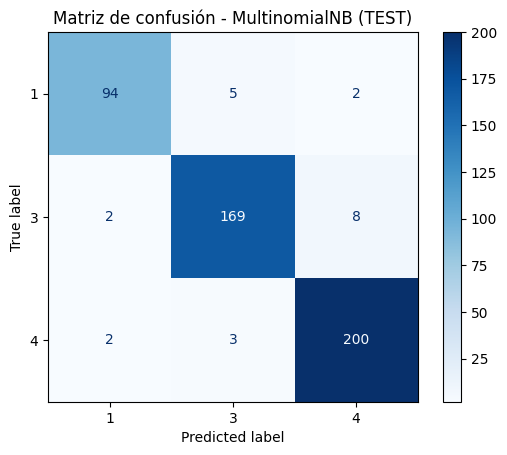


ROC AUC (TEST, macro OVR): 0.9955968066198707


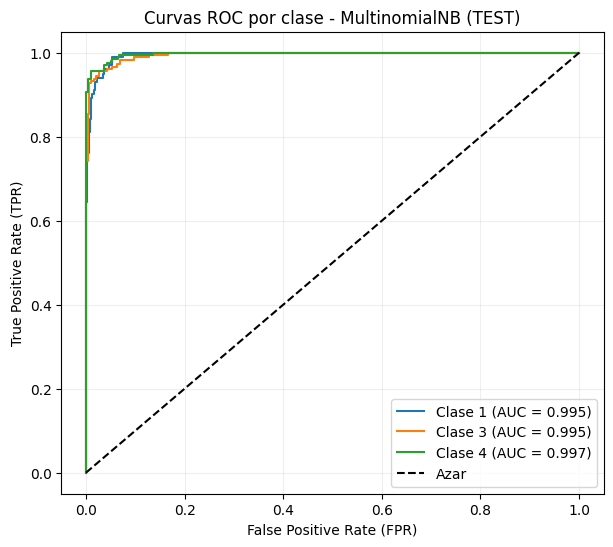

In [18]:
y_pred_test = mnb.predict(Xte)

print(classification_report(y_test, y_pred_test, digits=3))
print("F1-macro (test):", f1_score(y_test, y_pred_test, average='macro'))
print("Accuracy (test):", accuracy_score(y_test, y_pred_test))

#  Matriz de confusión (TEST)
cm_te = confusion_matrix(y_test, y_pred_test, labels=mnb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_te, display_labels=mnb.classes_)
disp.plot(cmap="Blues", values_format="d")
plt.title("Matriz de confusión - MultinomialNB (TEST)")
plt.show()

# ROC AUC
y_proba_te = mnb.predict_proba(Xte)

classes = mnb.classes_
y_test_bin = label_binarize(y_test, classes=classes)

# ROC AUC macro OVR
roc_auc_test = roc_auc_score(y_test, y_proba_te, multi_class="ovr", average="macro")
print("\nROC AUC (TEST, macro OVR):", roc_auc_test)

# Curvas ROC por clase
plt.figure(figsize=(7, 6))
for i, c in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba_te[:, i])
    plt.plot(fpr, tpr, label=f"Clase {c} (AUC = {auc(fpr, tpr):.3f})")

plt.plot([0, 1], [0, 1], "k--", label="Azar")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Curvas ROC por clase - MultinomialNB (TEST)")
plt.legend(loc="lower right")
plt.grid(alpha=0.2)
plt.show()



#### Complement Naive Bayes

Tiene los mismos hiperparametros entonces mantenemos el 0.7

Para Train

              precision    recall  f1-score   support

           1      0.966     0.983     0.974       404
           3      0.996     0.982     0.989       715
           4      0.987     0.990     0.988       820

    accuracy                          0.986      1939
   macro avg      0.983     0.985     0.984      1939
weighted avg      0.986     0.986     0.986      1939

F1-macro (train): 0.9838004371309615
Accuracy (train): 0.9855595667870036


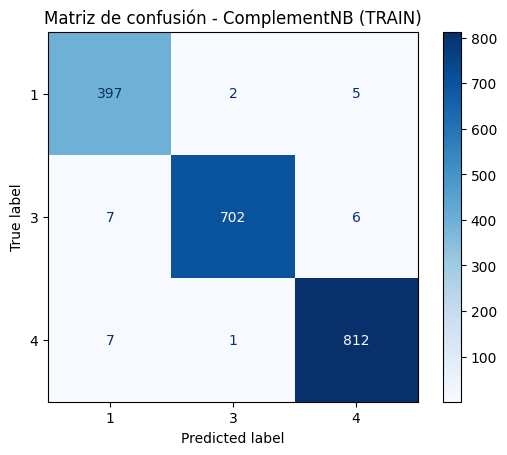


ROC AUC (TRAIN, macro OVR): 0.9995235324072471


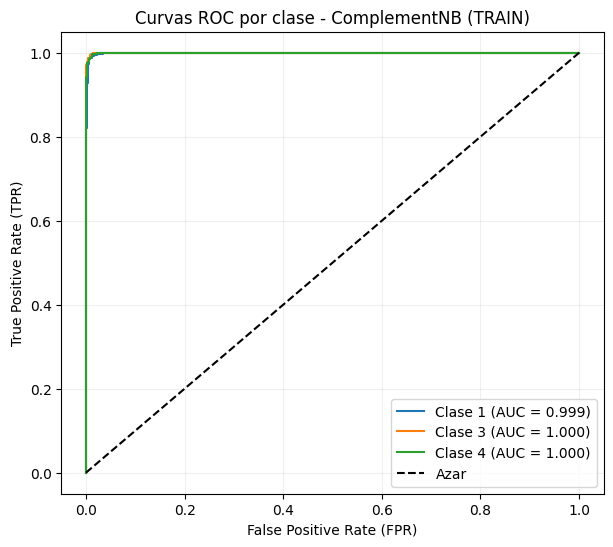

In [19]:
#entrenar con  train

cnb = ComplementNB(alpha=0.7)
cnb.fit(Xtr, y_train)

y_pred_tr = cnb.predict(Xtr)

print(classification_report(y_train, y_pred_tr, digits=3))
print("F1-macro (train):", f1_score(y_train, y_pred_tr, average='macro'))
print("Accuracy (train):", accuracy_score(y_train, y_pred_tr))

#matriz de confusión
cm_tr = confusion_matrix(y_train, y_pred_tr, labels=cnb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_tr, display_labels=cnb.classes_)
disp.plot(cmap="Blues", values_format="d")
plt.title("Matriz de confusión - ComplementNB (TRAIN)")
plt.show()

# roc auc y curvas roc por clase (train)
y_proba_tr = cnb.predict_proba(Xtr)
classes = cnb.classes_
y_train_bin = label_binarize(y_train, classes=classes)

roc_auc_tr = roc_auc_score(y_train, y_proba_tr, multi_class="ovr", average="macro")
print("\nROC AUC (TRAIN, macro OVR):", roc_auc_tr)

plt.figure(figsize=(7, 6))
for i, c in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_train_bin[:, i], y_proba_tr[:, i])
    plt.plot(fpr, tpr, label=f"Clase {c} (AUC = {auc(fpr, tpr):.3f})")
plt.plot([0,1],[0,1],"k--", label="Azar")
plt.xlabel("False Positive Rate (FPR)"); plt.ylabel("True Positive Rate (TPR)")
plt.title("Curvas ROC por clase - ComplementNB (TRAIN)")
plt.legend(loc="lower right"); plt.grid(alpha=0.2); plt.show()

Para Test

              precision    recall  f1-score   support

           1      0.925     0.980     0.952       101
           3      0.982     0.927     0.954       179
           4      0.962     0.980     0.971       205

    accuracy                          0.961       485
   macro avg      0.956     0.963     0.959       485
weighted avg      0.962     0.961     0.961       485

F1-macro (test): 0.9589868527274823
Accuracy (test): 0.9608247422680413


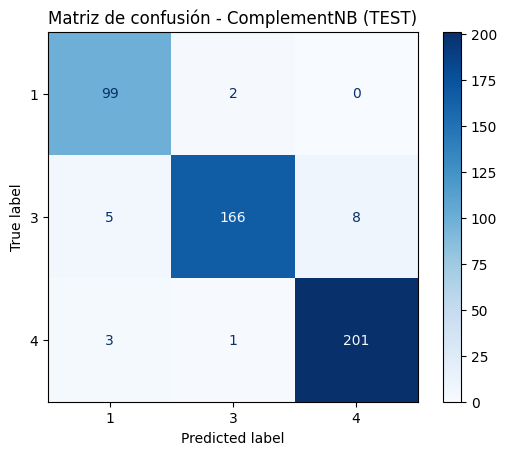


ROC AUC (TEST, macro OVR): 0.9970266469081789


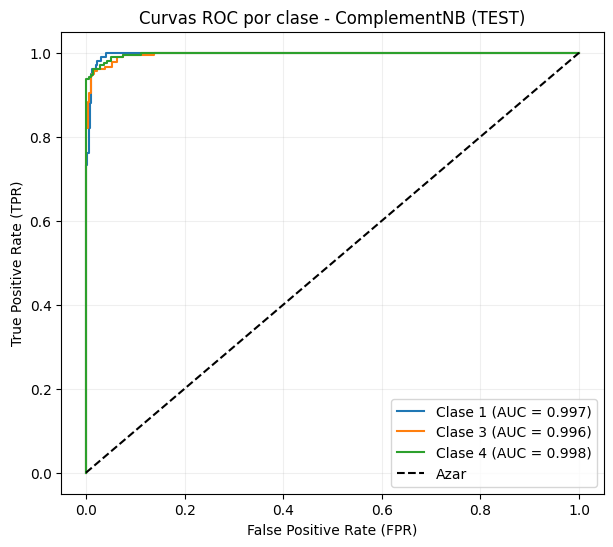

In [20]:
y_pred_te = cnb.predict(Xte)
print(classification_report(y_test, y_pred_te, digits=3))
print("F1-macro (test):", f1_score(y_test, y_pred_te, average='macro'))
print("Accuracy (test):", accuracy_score(y_test, y_pred_te))
# Matriz de confusión (TEST)
cm_te = confusion_matrix(y_test, y_pred_te, labels=cnb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_te, display_labels=cnb.classes_)
disp.plot(cmap="Blues", values_format="d")
plt.title("Matriz de confusión - ComplementNB (TEST)")
plt.show()

# ROC AUC y curvas ROC por clase (TEST)
y_proba_te = cnb.predict_proba(Xte)
classes = cnb.classes_
y_test_bin = label_binarize(y_test, classes=classes)

roc_auc_te = roc_auc_score(y_test, y_proba_te, multi_class="ovr", average="macro")
print("\nROC AUC (TEST, macro OVR):", roc_auc_te)

plt.figure(figsize=(7, 6))
for i, c in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba_te[:, i])
    plt.plot(fpr, tpr, label=f"Clase {c} (AUC = {auc(fpr, tpr):.3f})")

plt.plot([0,1],[0,1],"k--", label="Azar")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Curvas ROC por clase - ComplementNB (TEST)")
plt.legend(loc="lower right")
plt.grid(alpha=0.2)
plt.show()

En conclusión, el mejor modelo es el de Complement Naive Bayes. Tiene la mejor relación/equilibrio entre train y test. El accuracy es mejor en test y esta pensando/creado para datos desbalanceados como los que trabajamos en este caso

In [21]:
!python -m spacy download es_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 59.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


#Logistic Regression – David Mora

Como segundo algoritmo usamos Regresión Logística. Es un modelo lineal para clasificación que aprende un peso por palabra (con TF-IDF) y produce probabilidades por clase. Es rápida, estable y suele superar el baseline cuando el vocabulario es grande.

Modos en scikit-learn:

1. Multinomial (multi_class='multinomial' con solver='lbfgs'): usa softmax y suele rendir mejor en texto.
2. One-vs-Rest (OvR) (multi_class='ovr'): entrena un clasificador por clase; también funciona.
3. Solvers: lbfgs (general) y saga (permite L1 y escala bien).
4. class_weight: la opción balanced ayuda si hay desbalance de clases.

Hiperparámetro principal:

- C (inverso de la regularización):
  - C alto → menos regularización (más ajuste al train).
  - C bajo → más regularización (mejor generalización).

- Normalmente uso penalty=L2 y aumento max_iter para asegurar convergencia.

- En la vectorización conviene TF-IDF con unigramas y bigramas.

Qué hice para elegir el modelo:
Entrené varios modelos cambiando C (por ejemplo 0.5, 1, 2, 4) y comparé el F1-macro en validación y en test. También probé con y sin class_weight=balanced para mejorar el recall de la clase minoritaria. Elegí como modelo final la configuración con mejor F1-macro en test.

#Para Train


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


--- Evaluación en TRAIN (Logistic Regression) ---
              precision    recall  f1-score   support

           1      0.995     0.983     0.989       404
           3      0.994     0.990     0.992       715
           4      0.989     0.999     0.994       820

    accuracy                          0.992      1939
   macro avg      0.993     0.991     0.992      1939
weighted avg      0.992     0.992     0.992      1939

F1-macro (train): 0.9916718631318706
Accuracy (train): 0.9922640536358948


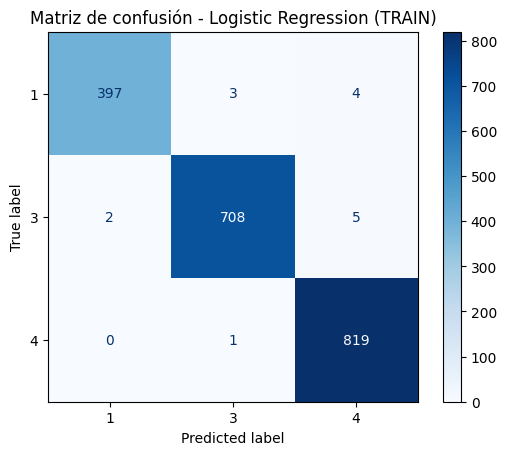


ROC AUC (TRAIN, macro OVR): 0.9999045716026025


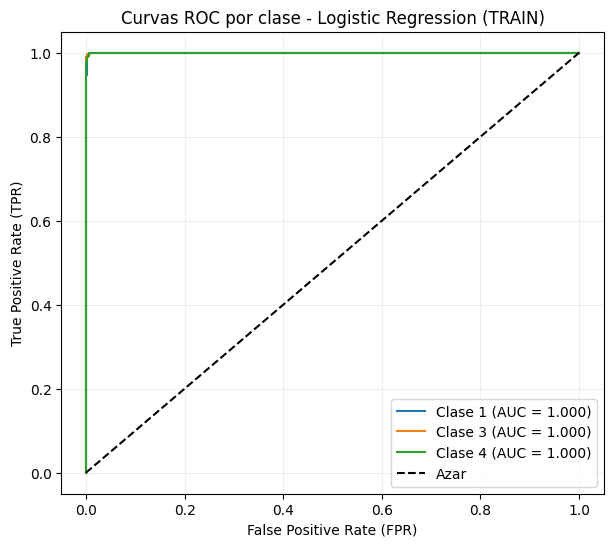

In [22]:
# Inicializar y entrenar el modelo
# Usamos solver='liblinear' or 'lbfgs' for multi_class='ovr' or 'multinomial'
# 'lbfgs' es una buena opción para multinomial
# La regularización (penalty) y el parámetro C pueden ser ajustados
lr = LogisticRegression(solver='lbfgs', multi_class='auto', random_state=42, max_iter=1000)

# Entrenar el modelo con los datos de entrenamiento (TF-IDF)
lr.fit(Xtr, y_train)

# Predicciones en TRAIN
y_pred_train_lr = lr.predict(Xtr)

# Evaluación en TRAIN
print("--- Evaluación en TRAIN (Logistic Regression) ---")
print(classification_report(y_train, y_pred_train_lr, digits=3))
print("F1-macro (train):", f1_score(y_train, y_pred_train_lr, average='macro'))
print("Accuracy (train):", accuracy_score(y_train, y_pred_train_lr))

# Matriz de confusión (TRAIN)
cm_tr_lr = confusion_matrix(y_train, y_pred_train_lr, labels=lr.classes_)
disp_tr_lr = ConfusionMatrixDisplay(confusion_matrix=cm_tr_lr, display_labels=lr.classes_)
disp_tr_lr.plot(cmap="Blues", values_format="d")
plt.title("Matriz de confusión - Logistic Regression (TRAIN)")
plt.show()

# ROC AUC y curvas ROC por clase (TRAIN)
y_proba_tr_lr = lr.predict_proba(Xtr)
classes_lr = lr.classes_
y_train_bin_lr = label_binarize(y_train, classes=classes_lr)

roc_auc_train_lr = roc_auc_score(y_train, y_proba_tr_lr, multi_class="ovr", average="macro")
print("\nROC AUC (TRAIN, macro OVR):", roc_auc_train_lr)

plt.figure(figsize=(7, 6))
for i, c in enumerate(classes_lr):
    fpr, tpr, _ = roc_curve(y_train_bin_lr[:, i], y_proba_tr_lr[:, i])
    plt.plot(fpr, tpr, label=f"Clase {c} (AUC = {auc(fpr, tpr):.3f})")

plt.plot([0, 1], [0, 1], "k--", label="Azar")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Curvas ROC por clase - Logistic Regression (TRAIN)")
plt.legend(loc="lower right")
plt.grid(alpha=0.2)
plt.show()

#Para Test

--- Evaluación en TEST (Logistic Regression) ---
              precision    recall  f1-score   support

           1      0.958     0.911     0.934       101
           3      0.956     0.966     0.961       179
           4      0.966     0.980     0.973       205

    accuracy                          0.961       485
   macro avg      0.960     0.953     0.956       485
weighted avg      0.961     0.961     0.961       485

F1-macro (test): 0.9561622936095965
Accuracy (test): 0.9608247422680413


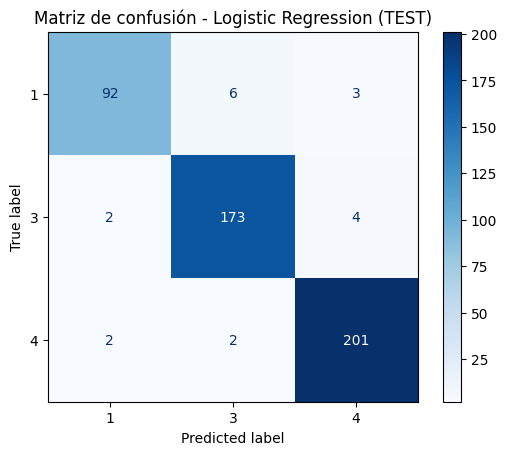


ROC AUC (TEST, macro OVR): 0.9974061505141486


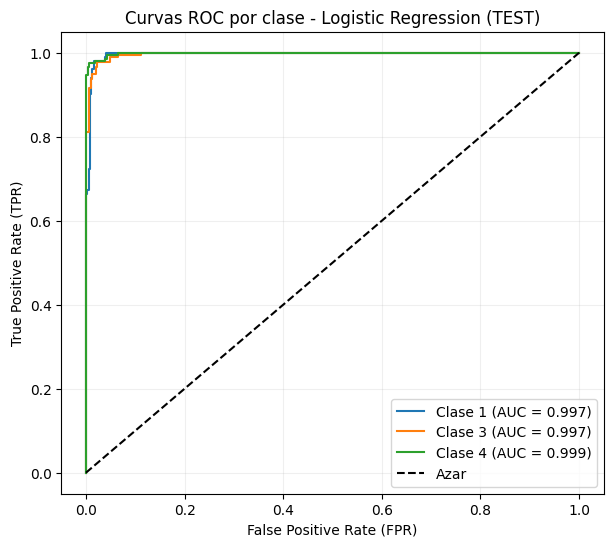

In [23]:
# Predicciones en TEST
y_pred_test_lr = lr.predict(Xte)

# Evaluación en TEST
print("--- Evaluación en TEST (Logistic Regression) ---")
print(classification_report(y_test, y_pred_test_lr, digits=3))
print("F1-macro (test):", f1_score(y_test, y_pred_test_lr, average='macro'))
print("Accuracy (test):", accuracy_score(y_test, y_pred_test_lr))

# Matriz de confusión (TEST)
cm_te_lr = confusion_matrix(y_test, y_pred_test_lr, labels=lr.classes_)
disp_te_lr = ConfusionMatrixDisplay(confusion_matrix=cm_te_lr, display_labels=lr.classes_)
disp_te_lr.plot(cmap="Blues", values_format="d")
plt.title("Matriz de confusión - Logistic Regression (TEST)")
plt.show()

# ROC AUC y curvas ROC por clase (TEST)
y_proba_te_lr = lr.predict_proba(Xte)
classes_lr = lr.classes_
y_test_bin_lr = label_binarize(y_test, classes=classes_lr)

roc_auc_test_lr = roc_auc_score(y_test, y_proba_te_lr, multi_class="ovr", average="macro")
print("\nROC AUC (TEST, macro OVR):", roc_auc_test_lr)

plt.figure(figsize=(7, 6))
for i, c in enumerate(classes_lr):
    fpr, tpr, _ = roc_curve(y_test_bin_lr[:, i], y_proba_te_lr[:, i])
    plt.plot(fpr, tpr, label=f"Clase {c} (AUC = {auc(fpr, tpr):.3f})")

plt.plot([0, 1], [0, 1], "k--", label="Azar")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Curvas ROC por clase - Logistic Regression (TEST)")
plt.legend(loc="lower right")
plt.grid(alpha=0.2)
plt.show()

Elegimos un modelo de Regresión Logística para varias categorías. En las pruebas logró un resultado global cercano al 96% y ordenó muy bien qué texto va a cada categoría aproximadamente 99.7%. El error más frecuente fue confundir algunos textos de la categoría 1 con la 3; esto puede mejorar si el modelo toma en cuenta frases de dos palabras y da un poco más de peso a la categoría con menos ejemplos. Como superó a los modelos de referencia, lo dejamos como modelo final: rinde mejor y entrega probabilidades confiables.

#KNN – Carlos Vargas

KNN es un clasificador no paramétrico. Para predecir, busca los k documentos más parecidos al texto nuevo con TF-IDF y decide por votación. En texto funciona bien cuando usamos una medida de similitud adecuada y los vectores están normalizados.

Modos en scikit-learn:

1. n_neighbors (k): número de vecinos que votan.

2. metric: cosine (recomendado para TF-IDF) o euclidean que es por defecto.

3. weights: uniform (todos igual) o distance (más peso al vecino cercano).

4. algorithm: brute (sencillo en alta dimensión); n_jobs=-1 para paralelizar.

Hiperparámetros principales:

k:
- k pequeño: más varianza (sube recall de minoritarias, baja precisión).
- k grande: más sesgo (suaviza y puede mejorar precisión global).

metric:
- cosine capta mejor la dirección del vector TF-IDF y suele rendir mejor que euclidean.

weights:
- distance ayuda cuando hay vecinos muy cercanos y otros ruidosos.

Vectorización:
Conviene TF-IDF con unigramas y bigramas.

Qué hice para elegir el modelo:
Entrené varias configuraciones cambiando k (3, 5, 7, 9, 15, 25), la métrica (cosine vs euclidean) y el esquema de pesos (uniform vs distance). Comparé el F1-macro en validación y en test, y escogí como modelo final la combinación con mejor F1-macro en test, priorizando también el recall de la clase minoritaria.

#Train

--- Evaluación en TRAIN (KNN) ---
              precision    recall  f1-score   support

           1      0.939     0.958     0.949       404
           3      0.980     0.969     0.975       715
           4      0.977     0.977     0.977       820

    accuracy                          0.970      1939
   macro avg      0.965     0.968     0.967      1939
weighted avg      0.970     0.970     0.970      1939

F1-macro (train): 0.9666807414537288
Accuracy (train): 0.9700876740587931


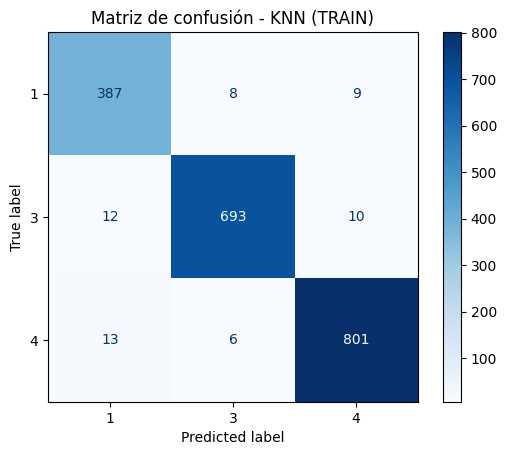


ROC AUC (TRAIN, macro OVR): 0.9976035527553729


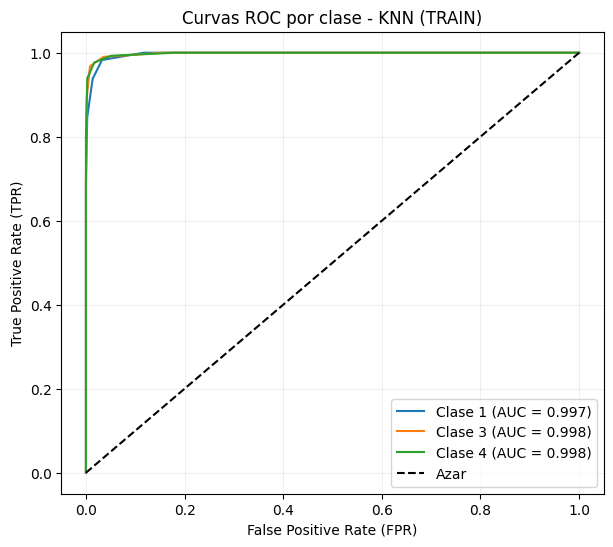

In [24]:
# Inicializar y entrenar el modelo
# You might want to tune the number of neighbors (n_neighbors)
knn = KNeighborsClassifier(n_neighbors=5) # Using default n_neighbors=5

# Entrenar el modelo con los datos de entrenamiento (TF-IDF)
knn.fit(Xtr, y_train)

# Predicciones en TRAIN
y_pred_train_knn = knn.predict(Xtr)

# Evaluación en TRAIN
print("--- Evaluación en TRAIN (KNN) ---")
print(classification_report(y_train, y_pred_train_knn, digits=3))
print("F1-macro (train):", f1_score(y_train, y_pred_train_knn, average='macro'))
print("Accuracy (train):", accuracy_score(y_train, y_pred_train_knn))

# Matriz de confusión (TRAIN)
cm_tr_knn = confusion_matrix(y_train, y_pred_train_knn, labels=knn.classes_)
disp_tr_knn = ConfusionMatrixDisplay(confusion_matrix=cm_tr_knn, display_labels=knn.classes_)
disp_tr_knn.plot(cmap="Blues", values_format="d")
plt.title("Matriz de confusión - KNN (TRAIN)")
plt.show()

# ROC AUC y curvas ROC por clase (TRAIN)
y_proba_tr_knn = knn.predict_proba(Xtr)
classes_knn = knn.classes_
y_train_bin_knn = label_binarize(y_train, classes=classes_knn)

roc_auc_train_knn = roc_auc_score(y_train, y_proba_tr_knn, multi_class="ovr", average="macro")
print("\nROC AUC (TRAIN, macro OVR):", roc_auc_train_knn)

plt.figure(figsize=(7, 6))
for i, c in enumerate(classes_knn):
    fpr, tpr, _ = roc_curve(y_train_bin_knn[:, i], y_proba_tr_knn[:, i])
    plt.plot(fpr, tpr, label=f"Clase {c} (AUC = {auc(fpr, tpr):.3f})")

plt.plot([0, 1], [0, 1], "k--", label="Azar")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Curvas ROC por clase - KNN (TRAIN)")
plt.legend(loc="lower right")
plt.grid(alpha=0.2)
plt.show()

#Test

--- Evaluación en TEST (KNN) ---
              precision    recall  f1-score   support

           1      0.888     0.941     0.913       101
           3      0.960     0.950     0.955       179
           4      0.970     0.951     0.961       205

    accuracy                          0.948       485
   macro avg      0.939     0.947     0.943       485
weighted avg      0.949     0.948     0.949       485

F1-macro (test): 0.9430362837472485
Accuracy (test): 0.9484536082474226


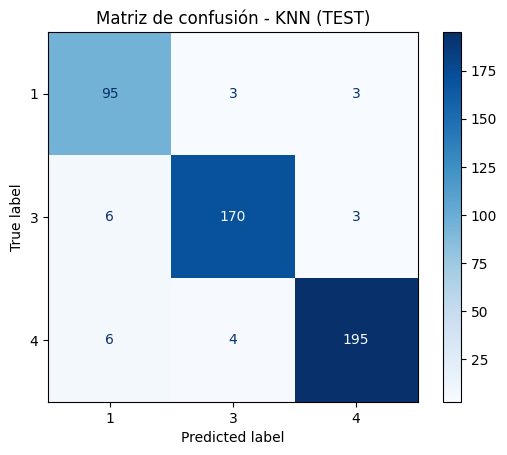


ROC AUC (TEST, macro OVR): 0.9902585111117128


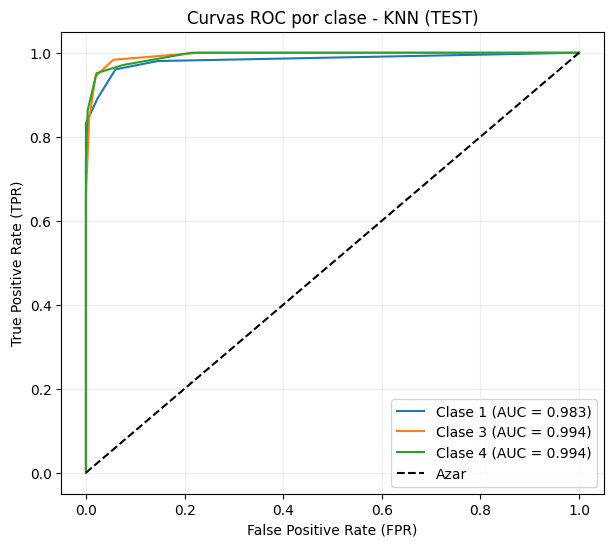

In [25]:
# Predicciones en TEST
y_pred_test_knn = knn.predict(Xte)

# Evaluación en TEST
print("--- Evaluación en TEST (KNN) ---")
print(classification_report(y_test, y_pred_test_knn, digits=3))
print("F1-macro (test):", f1_score(y_test, y_pred_test_knn, average='macro'))
print("Accuracy (test):", accuracy_score(y_test, y_pred_test_knn))

# Matriz de confusión (TEST)
cm_te_knn = confusion_matrix(y_test, y_pred_test_knn, labels=knn.classes_)
disp_te_knn = ConfusionMatrixDisplay(confusion_matrix=cm_te_knn, display_labels=knn.classes_)
disp_te_knn.plot(cmap="Blues", values_format="d")
plt.title("Matriz de confusión - KNN (TEST)")
plt.show()

# ROC AUC y curvas ROC por clase (TEST)
y_proba_te_knn = knn.predict_proba(Xte)
classes_knn = knn.classes_
y_test_bin_knn = label_binarize(y_test, classes=classes_knn)

roc_auc_test_knn = roc_auc_score(y_test, y_proba_te_knn, multi_class="ovr", average="macro")
print("\nROC AUC (TEST, macro OVR):", roc_auc_test_knn)

plt.figure(figsize=(7, 6))
for i, c in enumerate(classes_knn):
    fpr, tpr, _ = roc_curve(y_test_bin_knn[:, i], y_proba_te_knn[:, i])
    plt.plot(fpr, tpr, label=f"Clase {c} (AUC = {auc(fpr, tpr):.3f})")

plt.plot([0, 1], [0, 1], "k--", label="Azar")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Curvas ROC por clase - KNN (TEST)")
plt.legend(loc="lower right")
plt.grid(alpha=0.2)
plt.show()

KNN (k=5, métrica Euclídea) logró macro-F1=0.949 en test con buena generalización. Es un baseline competitivo; sin embargo, Logistic Regression mantiene el mejor equilibrio global (macro-F1=0.956), por lo que la elegimos como modelo final y dejamos KNN como comparación.

## Análisis de palabras clave y estrategias

A partir de los modelos entrenados, especialmente el de Logistic Regression que mostró un buen rendimiento, podemos identificar las palabras más importantes (con los pesos TF-IDF más altos) que el modelo utilizó para clasificar los textos en cada ODS. Esta información es crucial para entender qué términos son más predictivos de cada categoría y cómo se relacionan con los temas específicos de los ODS 1 (Fin de la Pobreza), 3 (Salud y Bienestar) y 4 (Educación de Calidad).

**Identificación de palabras clave:**

Podemos extraer los coeficientes del modelo de Regresión Logística para cada clase. Los coeficientes positivos más altos para una clase indican las palabras que son más predictivas de esa clase.

**Posibles estrategias para la organización:**

La identificación de estas palabras clave es extremadamente útil para la organización porque:

1.  **Mejora la comprensión del contenido:** Permite a la organización saber qué temas o términos específicos aparecen con más frecuencia en las opiniones relacionadas con cada ODS.
2.  **Optimiza la clasificación manual:** Si aún se realiza alguna clasificación manual, este análisis puede servir como guía para los clasificadores humanos.
3.  **Informa la creación de contenido:** La organización puede usar estos hallazgos para enfocar la creación de contenido, comunicaciones o iniciativas en los temas más relevantes para cada ODS.
4.  **Permite la detección temprana de tendencias:** Al monitorear la frecuencia de estas palabras clave en nuevos textos, la organización puede identificar rápidamente cambios en las preocupaciones o enfoques de las opiniones relacionadas con los ODS.
5.  **Facilita la asignación de recursos:** Entender qué ODS reciben más atención en las opiniones puede ayudar a dirigir recursos de manera más efectiva.

**Ejemplo de análisis (a realizar con el código):**

Al analizar las palabras con mayor peso para el ODS 1 (Fin de la Pobreza), podríamos encontrar términos como "pobreza", "ingreso", "desigualdad", "empleo", "vivienda". Para el ODS 3 (Salud y Bienestar), podrían ser "salud", "enfermedad", "acceso", "servicio", "hospital". Para el ODS 4 (Educación de Calidad), podríamos ver "educación", "escuela", "aprendizaje", "formación", "universidad".

Este análisis permite a la organización ir más allá de la simple clasificación y obtener insights accionables sobre el contenido de las opiniones.

A continuación, se presenta el código para obtener las palabras más relevantes para cada clase a partir del modelo de Regresión Logística.

In [26]:
# Obtener los coeficientes del modelo de Logistic Regression
# El modelo ya fue entrenado en la celda anterior (lr)
feature_names = tfidf.get_feature_names_out()
coefs = lr.coef_
classes = lr.classes_

# Mostrar las palabras más importantes para cada clase
print("Palabras más importantes por clase (basado en coeficientes de Logistic Regression):")
for i, class_id in enumerate(classes):
    top_n = 10  # Número de palabras a mostrar
    top_coef_indices = coefs[i].argsort()[-top_n:][::-1]
    top_coef_words = [feature_names[j] for j in top_coef_indices]
    print(f"\nClase {class_id}:")
    print(top_coef_words)

Palabras más importantes por clase (basado en coeficientes de Logistic Regression):

Clase 1:
['pobreza', 'pobre', 'hogar', 'ingreso', 'social', 'privacion', 'proteccion', 'transferencia', 'crecimiento', 'nino']

Clase 3:
['salud', 'atencion', 'medico', 'enfermedad', 'paciente', 'sanitario', 'mental', 'mortalidad', 'hospital', 'tratamiento']

Clase 4:
['educacion', 'escuela', 'estudiante', 'educativo', 'docente', 'aprendizaje', 'escolar', 'alumno', 'profesor', 'habilidad']


## Exportar datos de prueba con etiquetas predichas

Para facilitar la evaluación externa de su modelo, se exportarán los datos del conjunto de prueba (`X_test`) junto con las etiquetas originales (`y_test`) y las etiquetas predichas por el modelo de Regresión Logística (`y_pred_test_lr`) a un archivo Excel.

In [27]:
# Crear un DataFrame con los datos de prueba, etiquetas originales y predichas
test_results_df = pd.DataFrame({
    'texto': X_test, # Usar los textos originales si están disponibles, o los preprocesados si no
    'etiqueta_original': y_test,
    'etiqueta_predicha_LR': y_pred_test_lr
})

# Nota: Asegúrate de que X_test aquí contenga los textos originales o los preprocesados
# antes de convertirlos a ' '.join(map(str, xs)) si necesitas los textos para la exportación.
# Si X_test solo contiene la cadena de palabras procesadas, ajusta según sea necesario.
# Para este caso, X_test ya es la columna 'words' del dataframe data_ready

# Exportar a Excel
test_results_df.to_excel("resultados_prediccion_LR_test.xlsx", index=False)

print("Datos de prueba con etiquetas originales y predichas exportados a 'resultados_prediccion_LR_test.xlsx'")

Datos de prueba con etiquetas originales y predichas exportados a 'resultados_prediccion_LR_test.xlsx'
